<a href="https://colab.research.google.com/github/Molten-Ice/de-identification/blob/colab/11-working-stylegan2-de_identiciation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3

repo_dir = '/content/'
!wget -P {repo_dir} https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl

style_gan_dir = repo_dir + 'stylegan2-ada-pytorch'
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git {style_gan_dir}

!wget https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/cropped_face.jpg content/

!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 45.0 MB/s eta 0:00:00
  Attempting uninstall: imageio-ffmpeg
    Found existing installation: imageio-ffmpeg 0.4.8
    Uninstalling imageio-ffmpeg-0.4.8:
      Successfully uninstalled imageio-ffmpeg-0.4.8


In [33]:
import cv2
import torch
import pickle
import torchvision
import numpy as np
from PIL import Image, ImageOps
from facenet_pytorch import MTCNN

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, repo_dir + 'stylegan2-ada-pytorch')
import dnnlib
import torch_utils

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
assert device.type == "cuda", "Error, not running on gpu!"

In [16]:
with open('ffhq.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].to(device)  # torch.nn.Module
with open('ffhq.pkl', 'rb') as f:
    D = pickle.load(f)['D'].to(device)  # torch.nn.Module
# First time running through sets up pluggins and takes a few minutes, after that takes < 1 second
z = torch.randn([1, G.z_dim]).to(device) # 512 latent vector                  
img = G(z, None)  # NCHW, float32, dynamic range [-1, +1], None is class labels

#I think all losses are negative. The closer to 0 it is the worse it performs.
# e.g. -0.03 is random noise, -1.8 is a generated img

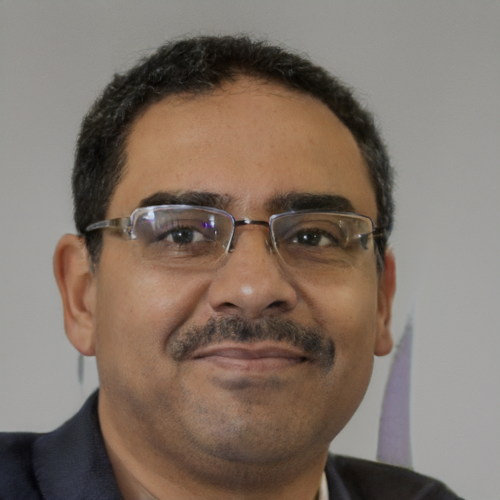

In [42]:
z = torch.randn([1, G.z_dim]).to(device) # 512 latent vector                  
img = G(z, None)  # NCHW, float32, dynamic range [-1, +1], None is class labels
print(D(img, None))

torch_grid = torchvision.utils.make_grid(img.cpu(), normalize = True)
generated_img = np.ascontiguousarray((torch_grid.permute(1,2,0).numpy()*255), dtype=np.uint8)
display(ImageOps.contain(Image.fromarray(generated_img), (500, 500)))

[1/1] faces used


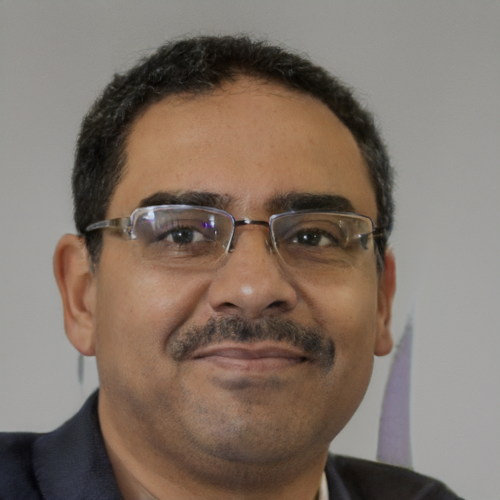

In [57]:
def generate_boxes_landmarks(img, mtcnn, device):
    all_boxes, all_probs, all_landmarks = mtcnn.detect(torch.Tensor(img).to(device), landmarks=True)
    all_boxes = [[int(x) for x in box] for box in all_boxes] 
    all_landmarks = [[[int(x), int(y)] for x, y in point] for point in all_landmarks] 

    boxes, probs, landmarks, centres = [], [], [], []
    threshold = 0.9
    for box, prob, landmark in zip(all_boxes, all_probs, all_landmarks):
            if prob >= threshold:
                boxes.append(box)
                probs.append(prob)
                landmarks.append(landmark)
    print(f"[{len(boxes)}/{len(all_boxes)}] faces used")
    return boxes, landmarks, probs


torch_grid = torchvision.utils.make_grid(img.cpu(), normalize = True)
generated_img = np.ascontiguousarray((torch_grid.permute(1,2,0).numpy()*255), dtype=np.uint8)

mtcnn = MTCNN(keep_all=True, device=device) #loading face detection model
boxes, landmarks, probs = generate_boxes_landmarks(generated_img, mtcnn, device)

if len(boxes) == 0:
    print("No faces found!! skip example (not yet implemented)")

box_generated = boxes[0]
# cv2.rectangle(generated_img, box_generated[:2], box_generated[2:], (255, 0, 0), 3)
display(ImageOps.contain(Image.fromarray(generated_img), (500, 500)))

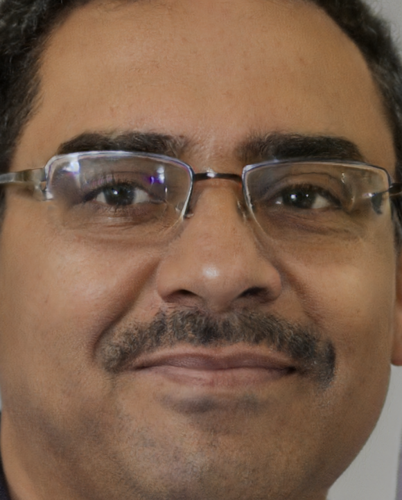

In [74]:
generated_cropped = img[:, :, box_generated[1]:box_generated[3], box_generated[0]:box_generated[2]]

torch_grid = torchvision.utils.make_grid(generated_cropped.cpu(), normalize = True)
generated_img = np.ascontiguousarray((torch_grid.permute(1,2,0).numpy()*255), dtype=np.uint8)
display(ImageOps.contain(Image.fromarray(generated_img), (500, 500)))

In [76]:
generated_cropped.shape

torch.Size([1, 3, 721, 580])

In [77]:
real_face = cv2.imread('cropped_face.jpg')
real_face = cv2.cvtColor(real_face, cv2.COLOR_BGR2RGB)

border_factor = 0.15
# border_width = int(real_face.shape[1]*border_factor)
# border_height = int(real_face.shape[0]*border_factor)

border_height = int(generated_cropped.shape[2]*border_factor)
border_width = int(generated_cropped.shape[3]*border_factor)

mask = torch.ones(generated_cropped.shape)#.to(device)#
mask[:, :, border_height:-border_height, border_width:-border_width] = 0

print(border_width, border_height)

87 108


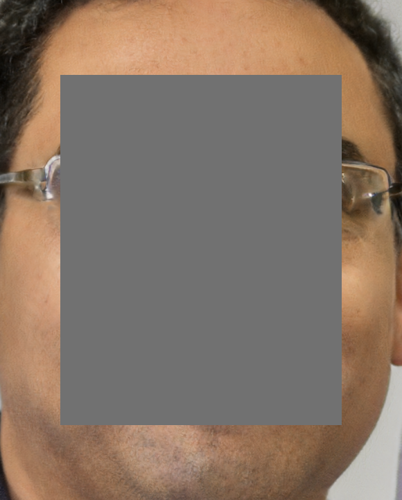

In [78]:
torch_grid = torchvision.utils.make_grid(generated_cropped.cpu()*mask, normalize = True)
generated_img = np.ascontiguousarray((torch_grid.permute(1,2,0).numpy()*255), dtype=np.uint8)
display(ImageOps.contain(Image.fromarray(generated_img), (500, 500)))

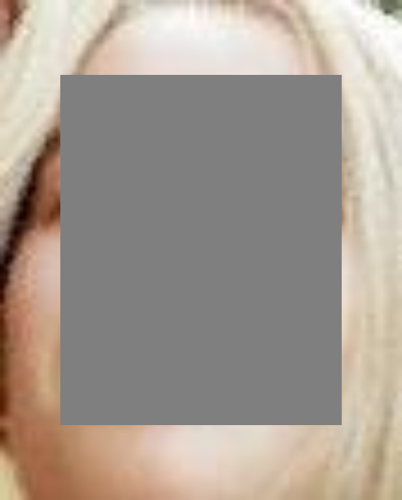

In [89]:
import torchvision.transforms as transforms
tensor_transform = transforms.ToTensor()

resize_face = cv2.resize(real_face, [generated_cropped.shape[3], generated_cropped.shape[2]]) 
real_face_tensor = (tensor_transform(resize_face).unsqueeze(dim=0)*2-1)

torch_grid = torchvision.utils.make_grid(real_face_tensor*mask, normalize = True)
generated_img = np.ascontiguousarray((torch_grid.permute(1,2,0).numpy()*255), dtype=np.uint8)
display(ImageOps.contain(Image.fromarray(generated_img), (500, 500)))

torch.Size([1, 3, 721, 580]) torch.Size([1, 3, 721, 580])


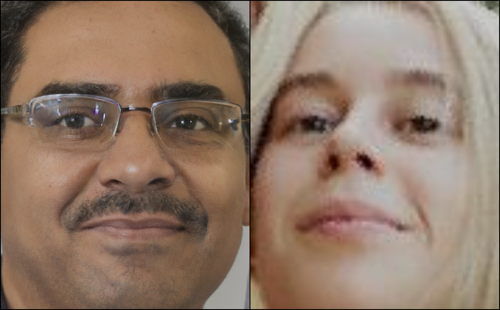

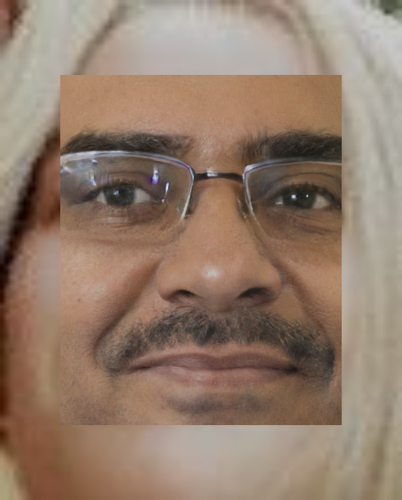

In [134]:
fixed_noise = z.clone().requires_grad_(True) #512 input latent vector
real_face = real_face_tensor.clone().to(device)
mask = mask.to(device)

generated_img = G(fixed_noise, None)[:, :, box_generated[1]:box_generated[3], box_generated[0]:box_generated[2]]
print(generated_img.shape, real_face.shape)

torch_grid = torchvision.utils.make_grid((torch.cat([generated_img, real_face], dim=0)).cpu(), normalize = True)
display_img = np.ascontiguousarray((torch_grid.permute(1,2,0).numpy()*255), dtype=np.uint8)
display(ImageOps.contain(Image.fromarray(display_img), (500, 500)))


torch_grid = torchvision.utils.make_grid((real_face*mask+generated_img*(1-mask)).cpu(), normalize = True)
display_img = np.ascontiguousarray((torch_grid.permute(1,2,0).numpy()*255), dtype=np.uint8)
display(ImageOps.contain(Image.fromarray(display_img), (500, 500)))

In [143]:
sum(p.numel() for p in G.parameters() if p.requires_grad)

0

In [135]:
import time
import torch.nn as nn
import torch.optim as optim

lr = 0.0003
iterations = 1500
lam = 0.1 # perceptual_loss factor
eval_interval = 50

progress = []

# criterion = nn.BCELoss()
optimizer = optim.Adam([fixed_noise], lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, iterations)
t_start = time.time()
for i in range(iterations):
    fake_face = G(fixed_noise, None)
    cropped_fake_face = fake_face[:, :, box_generated[1]:box_generated[3], box_generated[0]:box_generated[2]]
    contextual_loss = nn.functional.l1_loss(mask*cropped_fake_face, mask*real_face)
    perceptual_loss = D(fake_face, None)[0][0] # is unbounded. 0 is a awful prediction, more negative means more confident its a face

    complete_loss = contextual_loss + lam*perceptual_loss

    optimizer.zero_grad()
    complete_loss.backward()
    optimizer.step()
    scheduler.step()

    if i % eval_interval == 0:
        print(f"Losses, {i} iteration:: Complete:{complete_loss:.4f}, contextual:{contextual_loss:.4f}, perceptual:{lam*perceptual_loss:.4f} (after x0.1), time: {time.time()-t_start:.2f}s")
        progress.append((real_face*mask+cropped_fake_face*(1-mask)).cpu())



Losses, 0 iteration:: Complete:-0.2242, contextual:0.2616, perceptual:-0.4858 (after x0.1), time: 1.03s
Losses, 50 iteration:: Complete:-0.2994, contextual:0.2344, perceptual:-0.5338 (after x0.1), time: 10.34s
Losses, 100 iteration:: Complete:-0.3833, contextual:0.2170, perceptual:-0.6003 (after x0.1), time: 19.99s
Losses, 150 iteration:: Complete:-0.4313, contextual:0.2053, perceptual:-0.6366 (after x0.1), time: 29.39s
Losses, 200 iteration:: Complete:-0.4583, contextual:0.1932, perceptual:-0.6515 (after x0.1), time: 38.46s
Losses, 250 iteration:: Complete:-0.5070, contextual:0.1860, perceptual:-0.6929 (after x0.1), time: 47.43s
Losses, 300 iteration:: Complete:-0.5232, contextual:0.1788, perceptual:-0.7020 (after x0.1), time: 56.51s
Losses, 350 iteration:: Complete:-0.5403, contextual:0.1734, perceptual:-0.7137 (after x0.1), time: 65.38s
Losses, 400 iteration:: Complete:-0.5542, contextual:0.1675, perceptual:-0.7217 (after x0.1), time: 74.40s
Losses, 450 iteration:: Complete:-0.5447,

In [136]:
len(progress), progress[0].shape

(30, torch.Size([1, 3, 721, 580]))

In [141]:
real_face = cv2.imread('cropped_face.jpg')
real_face = cv2.cvtColor(real_face, cv2.COLOR_BGR2RGB)
real_face.shape

(102, 89, 3)

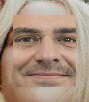

In [142]:
torch_grid = torchvision.utils.make_grid((progress[-1]).cpu(), normalize = True)
display_img = np.ascontiguousarray((torch_grid.permute(1,2,0).numpy()*255), dtype=np.uint8)
display_img = cv2.resize(display_img, [real_face.shape[1], real_face.shape[0]]) 
Image.fromarray(display_img)

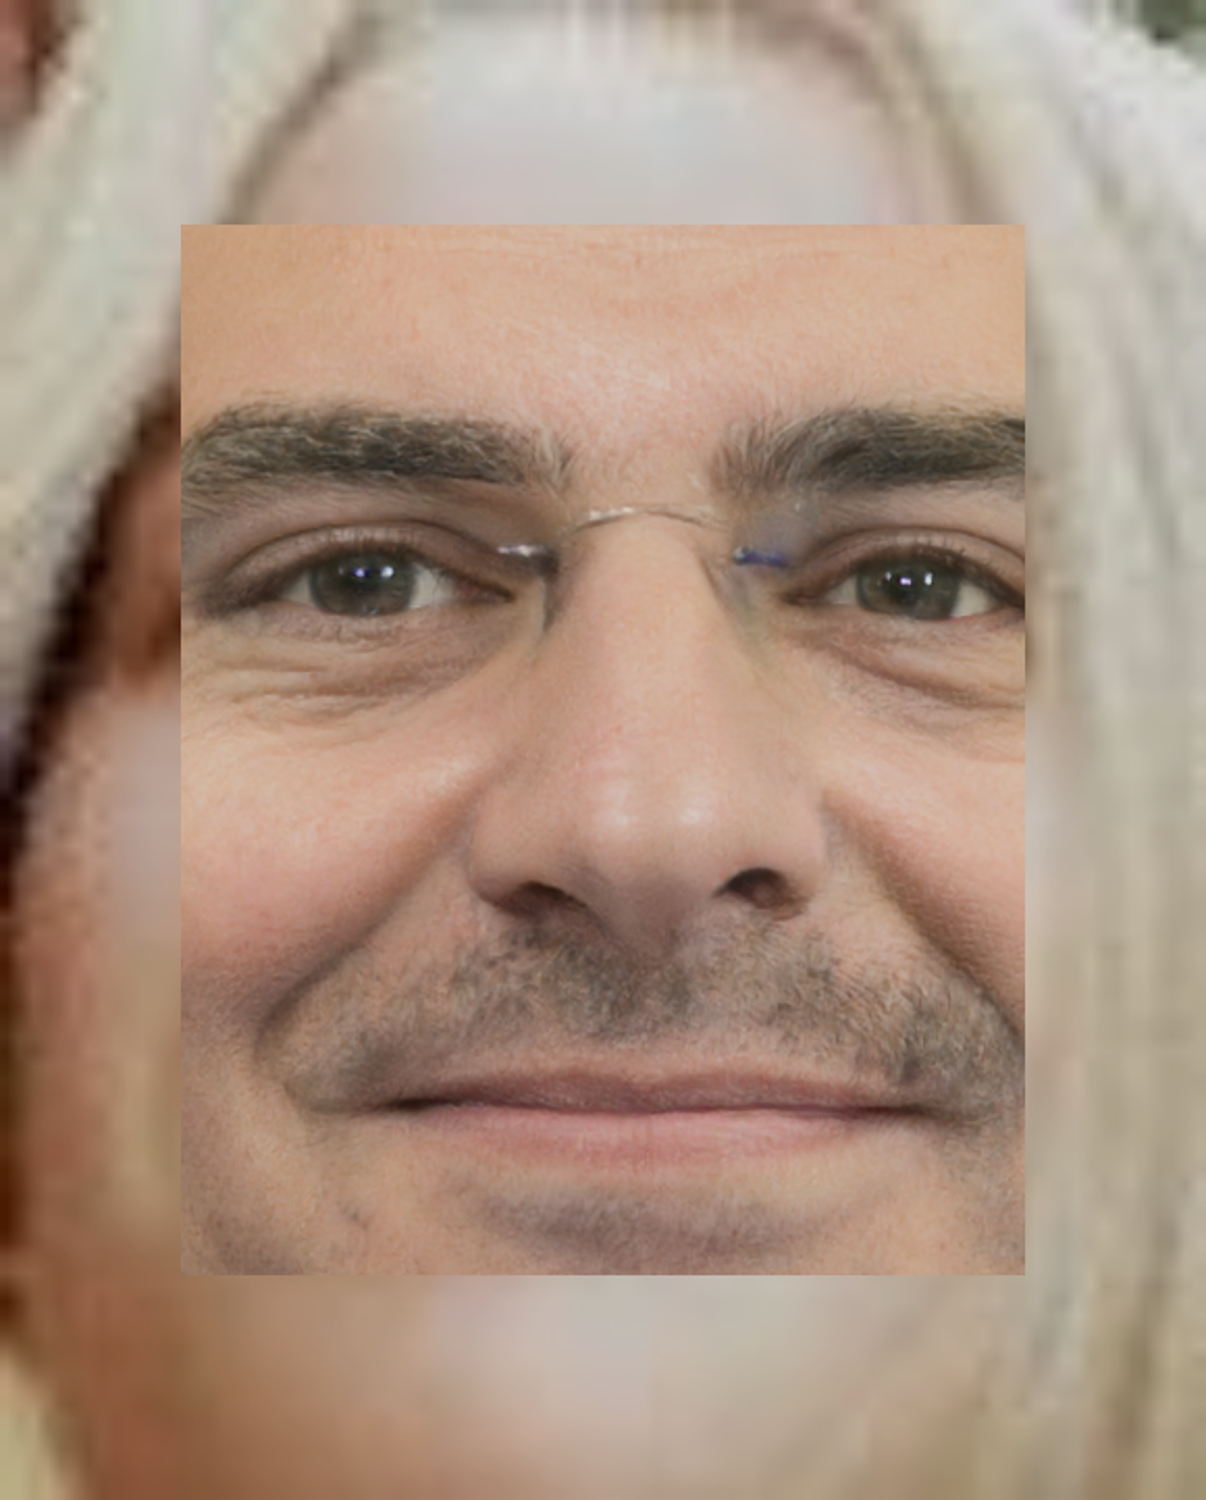

In [140]:

display(ImageOps.contain(Image.fromarray(display_img), (1500, 1500)))

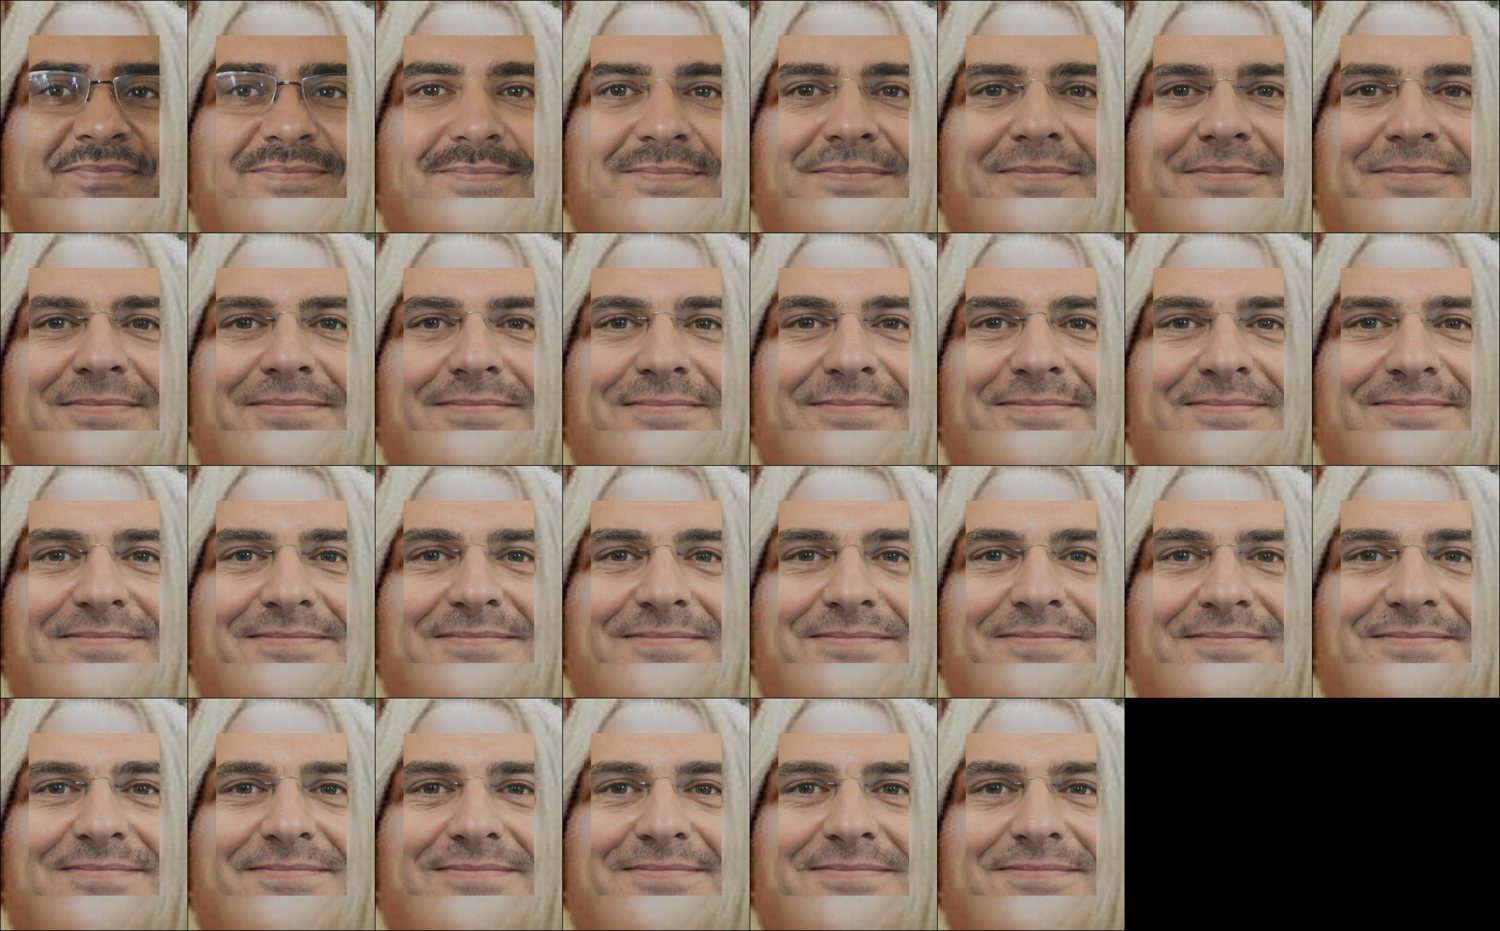

In [138]:
torch_grid = torchvision.utils.make_grid((torch.cat(progress, dim=0)).cpu(), normalize = True)
display_img = np.ascontiguousarray((torch_grid.permute(1,2,0).numpy()*255), dtype=np.uint8)
display(ImageOps.contain(Image.fromarray(display_img), (1500, 1500)))

In [ ]:
p

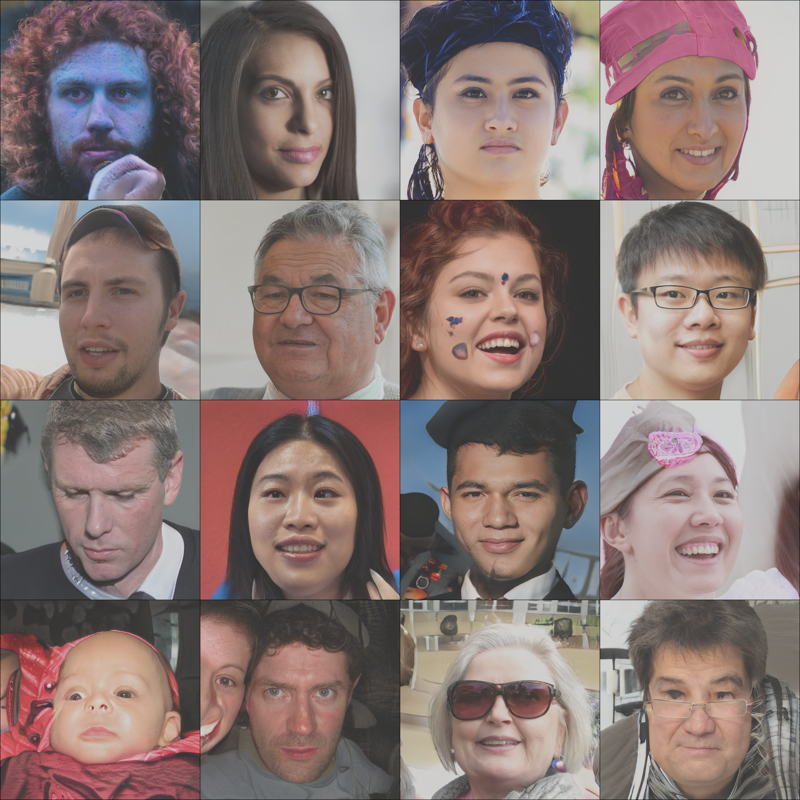

In [10]:
z = torch.randn([16, G.z_dim]).to(device) # 512 latent vector                  
img = G(z, None)  # NCHW, float32, dynamic range [-1, +1], None is class labels

torch_grid = torchvision.utils.make_grid(img.cpu(), normalize = True, nrow = 4)
display_img = Image.fromarray((torch_grid.permute(1,2,0).numpy()*255).astype(np.uint8))
display(ImageOps.contain(display_img, (800, 800)))